In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import warnings
import torch

import numpy as np
import pandas as pd
import tensorflow as tf

from datetime import datetime
from tqdm import tqdm

from stable_baselines3 import PPO
from sb3_contrib import MaskablePPO

from dice_rl.data.tf_offpolicy_dataset import TFOffpolicyDataset

from medical_rl.libs.RL import Model
from medical_rl.libs.envs import get_env
from medical_rl.libs.cluster import get_data_clustered_completed
from medical_rl.data_formatters.amsterdam import AmsterdamFormatter

from dice_rl_TU_Vienna.wrappers import AbsorbingWrapper, LoopingWrapper
from dice_rl_TU_Vienna.environment import test_env
from dice_rl_TU_Vienna.estimators.tabular.test import test_auxiliary_estimates
from dice_rl_TU_Vienna.estimators.tabular.tabular_OffPE import AuxiliaryEstimates
from dice_rl_TU_Vienna.utils.general import iterate_print
from dice_rl_TU_Vienna.utils.os import os_path_join

from plugins.medical_rl.sepsis_amsterdam.config import *

In [39]:
pd.set_option("display.max_rows", 100)

In [40]:
datetime.now().isoformat()

'2025-02-03T14:14:54.338205'

In [41]:
seed = 42
n_clusters = 256
n_init = 10

n_obs = n_clusters + 2
n_act = 5

In [11]:
def RL_split_to_dataset(RL_split, tabular):

    id, t, obs, act, rew = RL_split

    id  = np.array(id,  dtype=np.int64)
    t   = np.array(t,   dtype=np.int64)
    obs = np.array(obs, dtype=np.int64 if tabular else np.float32)
    act = np.array(act, dtype=np.int64)
    rew = np.array(rew, dtype=np.float32)

    obs_init = []
    obs_next = []

    i_init = 0
    for i in range(len(id)):

        if i > 0 and id[i] != id[i-1]:
            i_init = i

        obs_init.append( obs[i_init] )

        if i == len(id) - 1 or id[i+1] != id[i]:
            obs_next.append( obs[i] )
        else:
            obs_next.append( obs[i+1] )

    obs_init = np.array(obs_init)
    obs_next = np.array(obs_next)

    return pd.DataFrame({
        "id": list(id),
        "t": list(t),
        "obs_init": list(obs_init),
        "obs": list(obs),
        "act": list(act),
        "rew": list(rew),
        "obs_next": list(obs_next),
    })

# Continuous

## Dataset

In [ ]:
def create_dataset_continuous():
    _, _, test, bounds = AmsterdamFormatter() \
        .load_random_split_and_bounds(dir_split)

    test.sort_values(["ID", "Length of Stay"], inplace=True)

    model = Model(5, 1024)
    model.load_weights( os.path.join(dir_policy["continuous"], f"policy.h5"))

    test = AmsterdamFormatter().RL_split(test)
    test = RL_split_to_dataset(test, tabular=False)
    test["probs_init"] = list( get_probs_continuous(test["obs_init"], model) )
    test["probs_next"] = list( get_probs_continuous(test["obs_next"], model) )

    obs_min = np.array(bounds[0])
    obs_max = np.array(bounds[1])

    test.to_parquet( os.path.join(dir_policy["continuous"], f"dataset.parquet") )
    np.save( os.path.join(dir_policy["continuous"], f"obs_min.npy"), obs_min, )
    np.save( os.path.join(dir_policy["continuous"], f"obs_max.npy"), obs_max, )


def get_probs_continuous(observation, model):
    o = observation
    o = list(o)
    o = tf.convert_to_tensor(o, tf.float32)

    l, _ = model(o)
    p = tf.nn.softmax(l, axis=1)
    p = np.array(p)

    return p

In [ ]:
create_dataset_continuous()

In [15]:
obs_min = np.load( os.path.join(dir_policy["continuous"], "obs_min.npy") )
obs_min[:100]

array([-8.06915820e-01, -9.54015851e-01, -9.53790426e-01, -2.54084524e-02,
       -2.32830763e+00, -2.44670534e+00, -1.45127904e+00, -1.45634305e+00,
       -2.97194242e+00, -3.48733473e+00, -3.22874856e+00, -7.29413033e-01,
       -3.08796191e+00, -3.08928204e+00, -3.03649926e+00, -1.08392823e+00,
       -2.19888973e+00, -2.25506067e+00, -2.35733342e+00, -2.00814128e+00,
       -6.15756035e+00, -6.53796244e+00, -5.98751926e+00, -8.12110126e-01,
       -2.61270351e+01, -2.29396400e+01, -2.70833540e+00, -8.45425034e+00,
       -9.53036118e+00, -1.81086807e+01, -4.54230976e+00, -3.67017102e+00,
       -4.41145515e+00, -3.99905181e+00, -7.06714690e-01, -4.77863938e-01,
       -4.77305025e-01, -4.74949658e-01, -7.41412878e-01, -1.17235243e+00,
       -1.16939533e+00, -1.15859377e+00, -1.04782426e+00, -8.63174260e-01,
       -2.40820289e+00, -9.52082348e+00, -4.63353023e-02, -3.78860283e+00,
       -3.77877259e+00, -3.76478910e+00, -4.32487205e-02, -7.42801905e-01,
       -4.85994720e+00, -

In [16]:
obs_max = np.load( os.path.join(dir_policy["continuous"], "obs_max.npy") )
obs_max[:100]

array([ 5.69423790e+01,  2.74104805e+01,  2.74050369e+01,  2.41096640e+00,
        8.48044205e+00,  1.47043753e+01,  1.43512983e+01,  2.34378076e+00,
        2.12411346e+01,  2.77196846e+01,  2.83973942e+01,  1.25085926e+00,
        4.95312119e+00,  5.04160357e+00,  5.04312611e+00,  3.50155783e+00,
        3.08868542e+01,  3.29250221e+01,  3.44894981e+01, -2.00814128e+00,
        2.74480343e+01,  2.14069958e+01,  2.07772083e+01,  5.10954618e-01,
        8.80081081e+00,  1.09015923e+01,  1.79302856e-01,  1.64076187e+02,
        2.00921219e+02,  2.06600082e+02,  1.00391424e+00,  5.10706177e+01,
        4.57524920e+00,  5.58103991e+00,  4.78265643e-01,  2.65454044e+01,
        2.70125237e+01,  2.74020386e+01,  2.39406729e+00,  5.19698048e+00,
        5.49257851e+00,  5.34956837e+00, -5.68367660e-01,  9.14467087e+01,
        2.24091644e+02,  8.96394897e+02, -4.63353023e-02,  1.30696144e+01,
        1.30436869e+01,  1.30009518e+01, -4.32487205e-02,  7.78269434e+00,
        6.25319290e+01,  

In [32]:
[ i for i, b in enumerate(obs_min < obs_max) if not b ]

[19, 46, 50, 66, 74, 90, 106, 114, 198, 259, 263, 267, 271, 288, 290, 292]

In [33]:
[ i for i, b in enumerate(obs_min <= obs_max) if not b ]

[]

In [42]:
dataset = pd.read_parquet(
    os.path.join(dir_dataset["continuous"], "dataset.parquet")
)
dataset.head()

,id,t,obs_init,obs,act,rew,obs_next,probs_init,probs_next
0,20,0,"[-0.0800016, -0.08865834, -0.08860586, -0.0254...","[-0.0800016, -0.08865834, -0.08860586, -0.0254...",1,0.0,"[-0.0800016, -0.08865834, -0.08860586, -0.0254...","[1.9520018e-30, 0.28778797, 0.007400115, 0.701...","[4.6153204e-07, 0.41843063, 0.09803962, 0.2416..."
1,20,1,"[-0.0800016, -0.08865834, -0.08860586, -0.0254...","[-0.0800016, -0.08865834, -0.08860586, -0.0254...",1,0.0,"[-0.0800016, -0.08865834, -0.08860586, -0.0254...","[1.9520018e-30, 0.28778797, 0.007400115, 0.701...","[1.3341968e-18, 0.99022615, 0.0011949288, 0.00..."
2,20,2,"[-0.0800016, -0.08865834, -0.08860586, -0.0254...","[-0.0800016, -0.08865834, -0.08860586, -0.0254...",1,0.0,"[-0.0800016, -0.08865834, -0.08860586, -0.0254...","[1.9520018e-30, 0.28778797, 0.007400115, 0.701...","[4.3437872e-23, 0.99479574, 5.7580583e-06, 0.0..."
3,20,3,"[-0.0800016, -0.08865834, -0.08860586, -0.0254...","[-0.0800016, -0.08865834, -0.08860586, -0.0254...",1,0.0,"[-0.0800016, -0.08865834, -0.08860586, -0.0254...","[1.9520018e-30, 0.28778797, 0.007400115, 0.701...","[9.325621e-10, 0.00401068, 0.008864737, 0.9811..."
4,20,4,"[-0.0800016, -0.08865834, -0.08860586, -0.0254...","[-0.0800016, -0.08865834, -0.08860586, -0.0254...",1,0.0,"[-0.0800016, -0.08865834, -0.08860586, -0.0254...","[1.9520018e-30, 0.28778797, 0.007400115, 0.701...","[4.656923e-15, 6.592461e-05, 0.0002901405, 0.9..."


# Tabular

## Dataset

In [ ]:
def create_dataset_tabular(features):
    train, _, test, _ = AmsterdamFormatter() \
        .load_random_split_and_bounds(dir_split)

    train_clustered = get_data_clustered_completed(
        data=train, column_labels=features,
        n_clusters=n_clusters, n_init=n_init, seed=seed, path=dir_clustering,
    )

    test_clustered = get_data_clustered_completed(
        data=test, column_labels=features,
        n_clusters=n_clusters, n_init=n_init, seed=seed, path=dir_clustering,
    )

    x = dataset_clustered_to_RL_split(train_clustered)
    y = dataset_clustered_to_RL_split(test_clustered)

    x = RL_split_to_dataset(x, tabular=True)
    y = RL_split_to_dataset(y, tabular=True)
    
    x.to_parquet( os.path.join(dir_clustering, "train.parquet") )
    y.to_parquet( os.path.join(dir_clustering, "test.parquet") )


def dataset_clustered_to_RL_split(df):
    return df["id"], df["t"], df["obs"], df["act"], df["rew"]

In [ ]:
features = [
    'RRmean (ABP) mean',
    'RRmean (NIBP) mean',
    'Leukozyten max',
    'Heartrate mean',
    'Heartrate std',
    'Glucose mean',
    'Respiratory Rate resp min',
    'Noradrenaline (Norepinefrine) max',
    'Thrombozyten max',
    'PTT max',
    'PEEP max',
    'Fluid balance',
    'SOFA score',
    'Age',
    'Gender',
    'Antibiotics',
]

create_dataset_tabular(features)

Trying to load data/medical_rl/sepsis_amsterdam/2025-01-30T11:42:45.694984/2025-01-30T12:01:58.273325/kmeans_model.pkl
Trying to load data/medical_rl/sepsis_amsterdam/2025-01-30T11:42:45.694984/2025-01-30T12:01:58.273325/kmeans_model.pkl


In [ ]:
train_clustered = pd.read_parquet(
    os.path.join(dir_clustering, "train.parquet")
)

train_clustered.head()

,id,t,obs_init,obs,act,rew,obs_next
0,11,0,163,163,3,0.0,165
1,11,1,163,165,1,1.0,257
2,11,2,163,257,3,0.0,257
3,66,0,41,41,0,0.0,252
4,66,1,41,252,0,0.0,41


In [ ]:
test_clustered = pd.read_parquet(
    os.path.join(dir_clustering, "test.parquet")
)

test_clustered.head()

,id,t,obs_init,obs,act,rew,obs_next
0,20,0,58,58,1,0.0,179
1,20,1,58,179,1,0.0,17
2,20,2,58,17,1,0.0,17
3,20,3,58,17,1,0.0,17
4,20,4,58,17,1,0.0,17


### `original`, `exploratory`, & `evaluation`

In [ ]:
tfoffpolicydataset = {
    name: TFOffpolicyDataset.load(dir_dataset[name])
        for name in names[1:]
}

data/medical_rl/sepsis_amsterdam/2025-01-30T11:42:45.694984/2025-01-30T12:01:58.273325/2025-01-31T10:25:32.802016/2025-01-31T10:43:36.878616/dataset-ctr.pkl
data/medical_rl/sepsis_amsterdam/2025-01-30T11:42:45.694984/2025-01-30T12:01:58.273325/2025-01-31T10:27:51.724072/2025-01-31T10:47:14.651297/dataset-ctr.pkl


In [ ]:
model  = {
    name: MaskablePPO.load(
        os.path.join(dir_policy["tabular"][name], "policy.zip")
    )
        for name in names[1:]
}

In [ ]:
print("getting env_train")
env_train, action_masks_train = get_env(
    n_clusters=n_clusters,
    data_clustered=train_clustered, )

print("getting env_test")
env_test, action_masks_test = get_env(
    n_clusters=n_clusters,
    data_clustered=test_clustered, )

env_test_absorbing = AbsorbingWrapper(env_test)
env_test_looping   = LoopingWrapper  (env_test)

getting env_train
getting env_test


In [ ]:
np.mean(action_masks_train == action_masks_test)

0.6542635658914728

In [ ]:
def get_probs_MaskablePPO(obs, model, action_masks):
    o = obs
    o = np.array(o)
    if tf.rank(o) == 0: o = tf.reshape(o, shape=[1, 1])
    o = torch.tensor(o)

    distribution = model.policy.get_distribution(o, action_masks[o])

    logits = np.array([
        distribution.log_prob( torch.tensor(action) ).detach().numpy()
            for action in range(n_act)
    ]).T
    probs = tf.nn.softmax(logits)
    probs = np.array(probs)

    return probs


def add_probs(df):
    df["probs_init"] = list( get_probs_MaskablePPO(df["obs_init"], model["evaluation"], action_masks_test) )
    df["probs_next"] = list( get_probs_MaskablePPO(df["obs_next"], model["evaluation"], action_masks_test) )
    return df


def normalize_timesteps(df, check_sorted=True):
    for id in df["id"].unique():
        f = df["id"] == id
        if check_sorted: assert np.all( np.diff(df.loc[f, "t"]) >= 0 )
        df.loc[f, "t"] = np.arange( len(df[f]) )

    return df


def TFOffpolicyDataset_to_dataset(tfoffpolicydataset):
    all_steps = tfoffpolicydataset.get_all_steps(include_terminal_steps=True)

    df_dict = {
        "id": [],
        "t": [],
        "obs_init": [],
        "obs": [],
        "act": [],
        "rew": [],
        "obs_next": [],
    }

    id = 0

    for i in tqdm( range( len(all_steps.step_type) ) ):

        if i > 0:
            if all_steps.step_type[i-1] == 2:
                id += 1

        t = all_steps.step_num[i]

        if all_steps.step_type[i] == 2:
            continue

        if all_steps.step_type[i] == 0:
            obs_init = all_steps.observation[i]

        obs = all_steps.observation[i]
        act = all_steps.action[i]
        rew = all_steps.reward[i]
        obs_next = all_steps.observation[i+1]

        df_dict["id"]      .append( int(id) )
        df_dict["t"]       .append( int(t) )
        df_dict["obs_init"].append( int(obs_init) )
        df_dict["obs"]     .append( int(obs) )
        df_dict["act"]     .append( int(act) )
        df_dict["rew"]     .append( float(rew) )
        df_dict["obs_next"].append( int(obs_next) )

    df = pd.DataFrame(df_dict)
    df = add_probs(df)
    df = normalize_timesteps(df)

    return df

In [ ]:
def create_datasets_tabular():
    dataset = {}

    dataset["original"] = test_clustered.copy()
    dataset["original"] = add_probs(dataset["original"])
    dataset["original"] = normalize_timesteps(dataset["original"])

    for name in names[1:]:
        dataset[name] = TFOffpolicyDataset_to_dataset(
            tfoffpolicydataset[name], )

    for name in names:
        dataset[name].to_parquet(
            os.path.join(dir_dataset[name], "dataset.parquet")
        )

100%|██████████| 189141/189141 [01:37<00:00, 1948.28it/s]


In [ ]:
create_datasets_tabular()

In [61]:
datasets = {
    name: pd.read_parquet( os.path.join(dir_dataset["tabular"][name], "dataset.parquet") )
        for name in names
}

In [62]:
for k, v in datasets.items():
    print(k)
    display( v.head() )

original


,id,t,obs_init,obs,act,rew,obs_next,probs_init,probs_next
0,20,0,58,58,1,0.0,179,"[0.0011493299, 5.6734436e-05, 0.00018769284, 8...","[0.18146195, 0.025168937, 0.018255623, 0.26202..."
1,20,1,58,179,1,0.0,17,"[0.0011493299, 5.6734436e-05, 0.00018769284, 8...","[0.00037134442, 0.026493562, 0.002265007, 0.97..."
2,20,2,58,17,1,0.0,17,"[0.0011493299, 5.6734436e-05, 0.00018769284, 8...","[0.00037134442, 0.026493562, 0.002265007, 0.97..."
3,20,3,58,17,1,0.0,17,"[0.0011493299, 5.6734436e-05, 0.00018769284, 8...","[0.00037134442, 0.026493562, 0.002265007, 0.97..."
4,20,4,58,17,1,0.0,17,"[0.0011493299, 5.6734436e-05, 0.00018769284, 8...","[0.00037134442, 0.026493562, 0.002265007, 0.97..."


exploratory


,id,t,obs_init,obs,act,rew,obs_next,probs_init,probs_next
0,0,0,97,97,2,0.0,104,"[0.010809051, 0.24719085, 0.32981429, 0.239039...","[0.07476817, 0.008716597, 0.0102634495, 0.9062..."
1,0,1,97,104,3,0.0,24,"[0.010809051, 0.24719085, 0.32981429, 0.239039...","[0.0064728586, 0.8788471, 0.085370675, 0.02930..."
2,0,2,97,24,1,0.0,122,"[0.010809051, 0.24719085, 0.32981429, 0.239039...","[0.0018696949, 0.98924035, 0.006734774, 0.0002..."
3,0,3,97,122,1,0.0,244,"[0.010809051, 0.24719085, 0.32981429, 0.239039...","[0.00048858585, 0.115405515, 0.8628949, 0.0204..."
4,0,4,97,244,2,0.0,48,"[0.010809051, 0.24719085, 0.32981429, 0.239039...","[0.038448803, 0.18999945, 0.26331097, 0.423967..."


evaluation


,id,t,obs_init,obs,act,rew,obs_next,probs_init,probs_next
0,0,0,97,97,1,0.0,42,"[0.010809051, 0.24719085, 0.32981429, 0.239039...","[0.011781467, 0.74776983, 0.03801048, 0.200461..."
1,0,1,97,42,1,0.0,42,"[0.010809051, 0.24719085, 0.32981429, 0.239039...","[0.011781467, 0.74776983, 0.03801048, 0.200461..."
2,0,2,97,42,3,0.0,25,"[0.010809051, 0.24719085, 0.32981429, 0.239039...","[0.0017155914, 0.8569119, 0.11510988, 0.017063..."
3,0,3,97,25,1,0.0,3,"[0.010809051, 0.24719085, 0.32981429, 0.239039...","[0.00061547494, 0.96726096, 0.029273251, 0.000..."
4,0,4,97,3,1,0.0,3,"[0.010809051, 0.24719085, 0.32981429, 0.239039...","[0.00061547494, 0.96726096, 0.029273251, 0.000..."


## Auxiliary Estimates

In [ ]:
auxiliary_estimates = {}

for name in iterate_print(names, "name"):
    path = dir_dataset["tabular"][name]
    auxiliary_estimates[name] = AuxiliaryEstimates(dataset[name], n_obs, n_act, path, verbosity=1)

/Users/richardweiss/Library/CloudStorage/OneDrive-Persönlich/Masterarbeit/dice_rl_TU_Vienna/dice_rl_plugins/estimators/tabular/test.py:195: DeprecationWarning: invalid escape sequence '\q'
  plt.suptitle(title_prefix + "; " + f"${x}" + ", \quad " + f"{y}$", y=1.025)


(s, a) visited:
{'absolute': 663, 'relative': 0.513953488372093}
(s, a) not visited:
{'absolute': 627, 'relative': 0.48604651162790696}

# dD_bar[i] == 0, but P_bar[i, :] != 0: 0
# dD_bar[i] == 0, but P_bar[:, i] != 0: 0
# dD_bar[i], but d0_bar[i] != 0: 0

# ---------------------------------------------------------------- # 



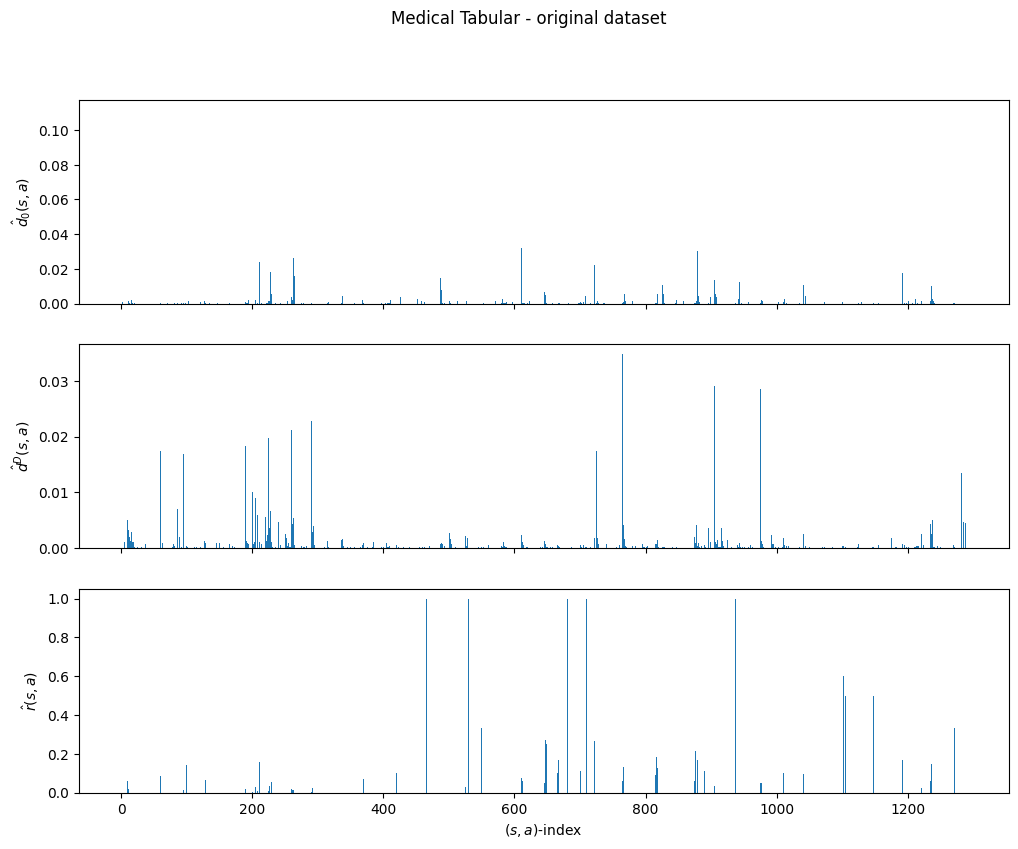

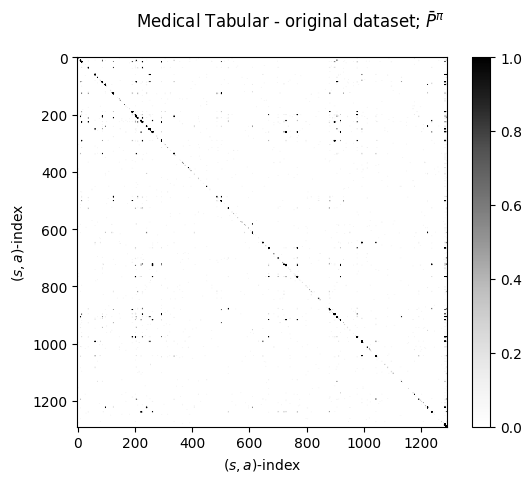

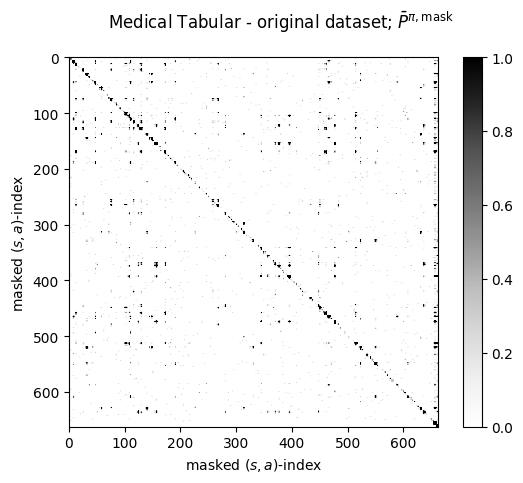

# ---------------------------------------------------------------- # 



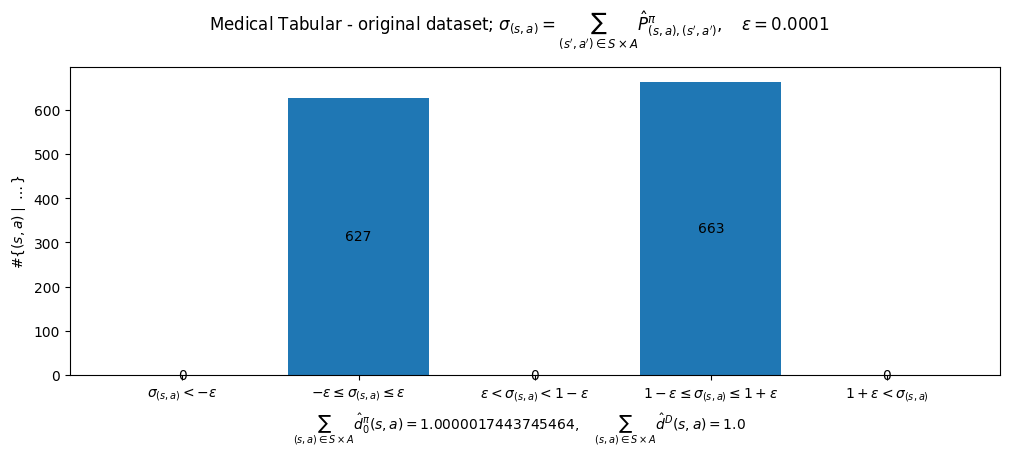

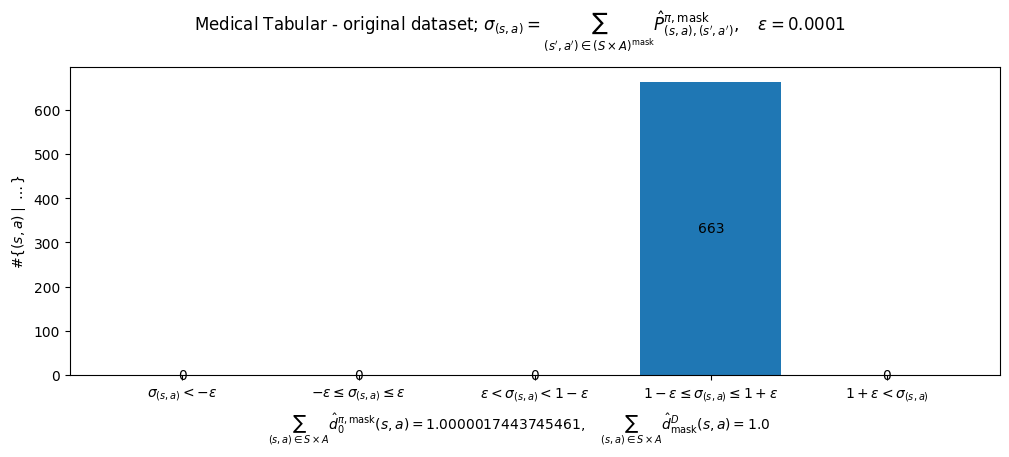

# ---------------------------------------------------------------- # 



In [ ]:
name = "original"

test_auxiliary_estimates(
    auxiliary_estimates=auxiliary_estimates[name],
    title_prefix=f"Medical Tabular - {name} dataset",
    dir=os.path.join(dir_images["tabular"], "auxiliary estimates"),
)

(s, a) visited:
{'absolute': 662, 'relative': 0.5131782945736434}
(s, a) not visited:
{'absolute': 628, 'relative': 0.4868217054263566}

# dD_bar[i] == 0, but P_bar[i, :] != 0: 0
# dD_bar[i] == 0, but P_bar[:, i] != 0: 0
# dD_bar[i], but d0_bar[i] != 0: 0

# ---------------------------------------------------------------- # 



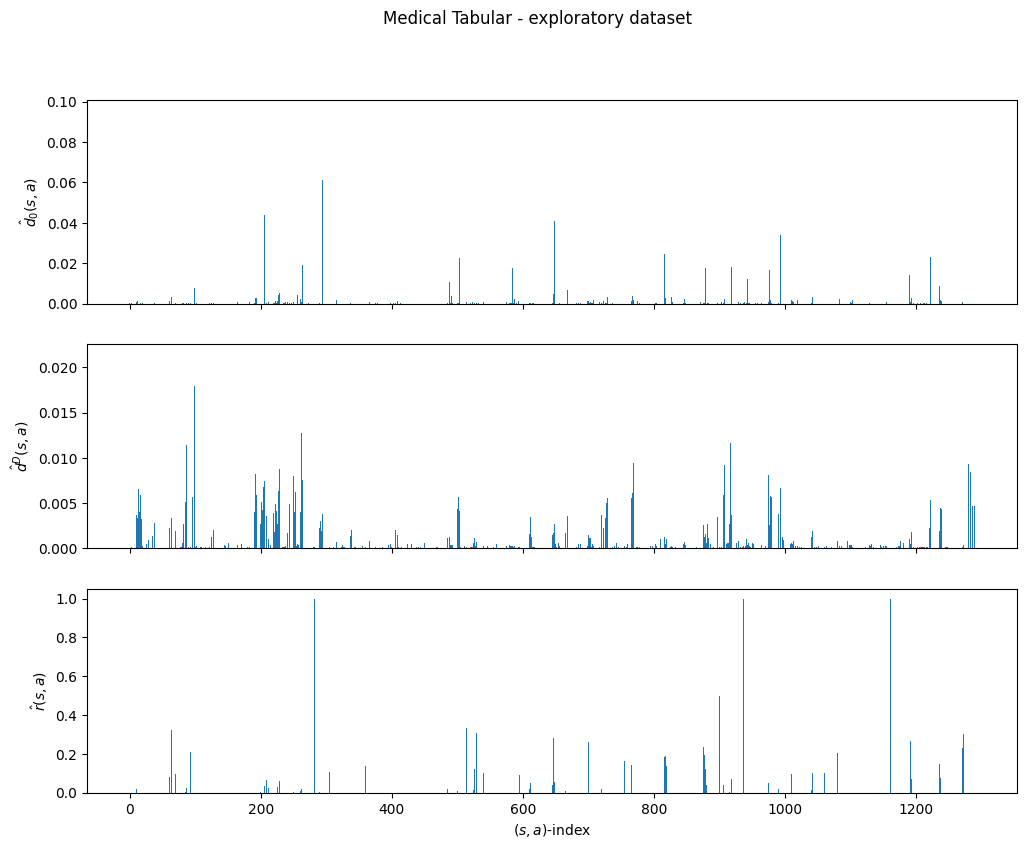

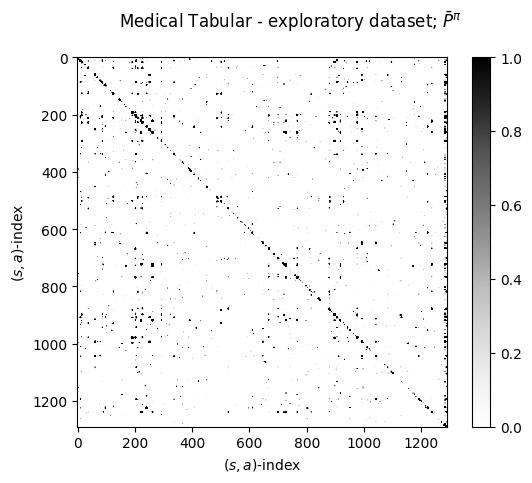

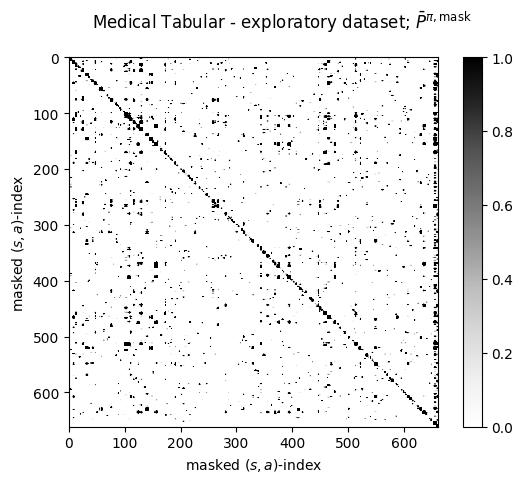

# ---------------------------------------------------------------- # 



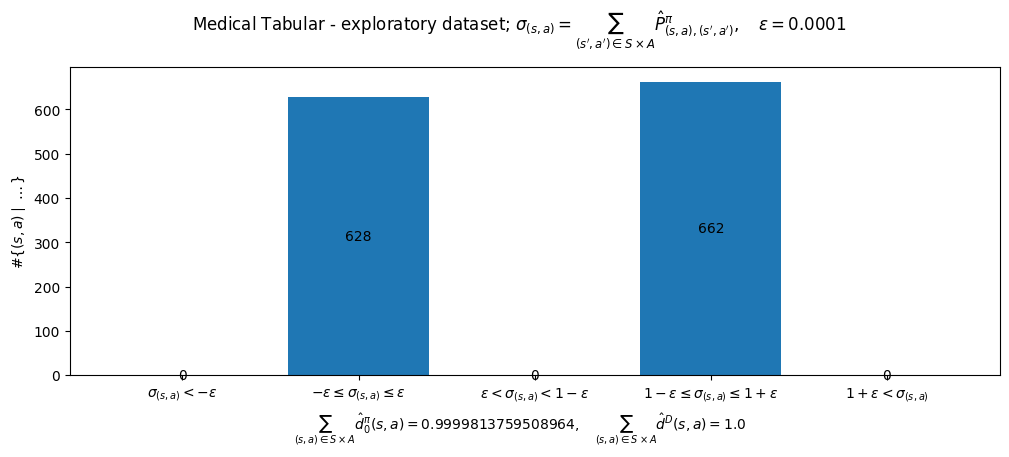

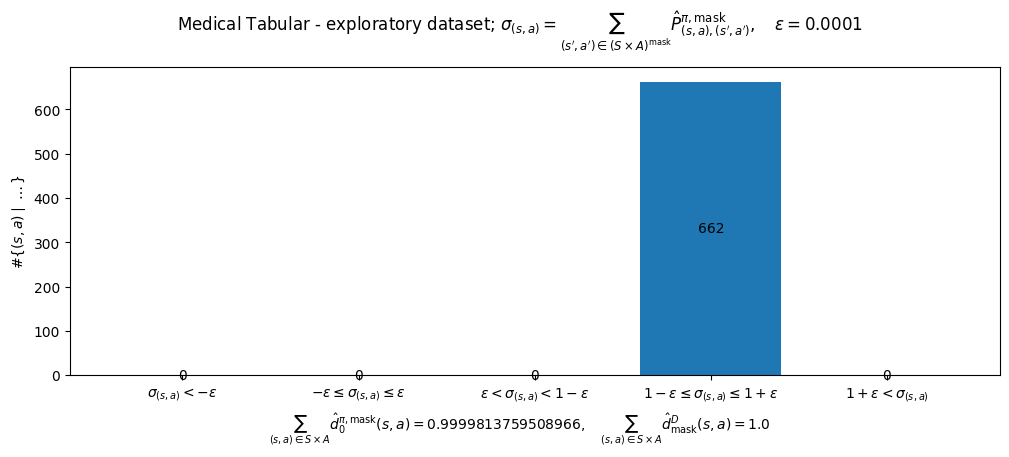

# ---------------------------------------------------------------- # 



In [ ]:
name = "exploratory"

test_auxiliary_estimates(
    auxiliary_estimates=auxiliary_estimates[name],
    title_prefix=f"Medical Tabular - {name} dataset",
    dir=os.path.join(dir_images["tabular"], "auxiliary estimates"),
)

(s, a) visited:
{'absolute': 569, 'relative': 0.44108527131782943}
(s, a) not visited:
{'absolute': 721, 'relative': 0.5589147286821705}

# dD_bar[i] == 0, but P_bar[i, :] != 0: 0
# dD_bar[i] == 0, but P_bar[:, i] != 0: 415
# dD_bar[i], but d0_bar[i] != 0: 57

# ---------------------------------------------------------------- # 



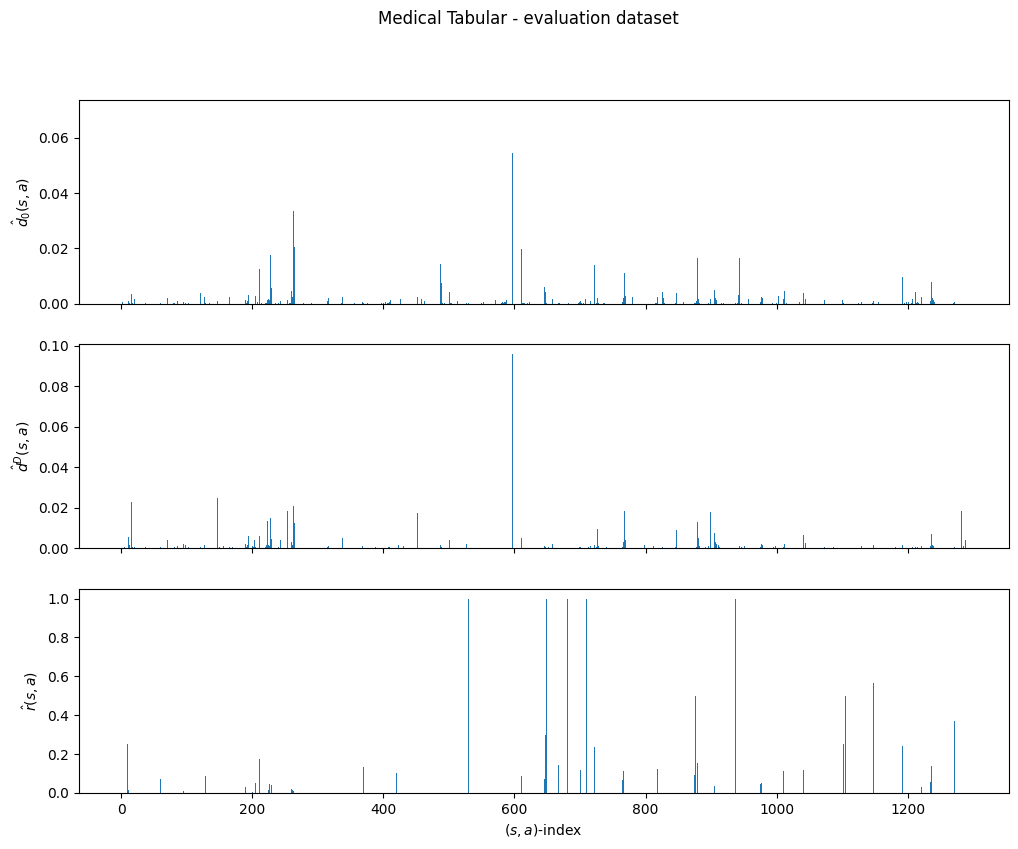

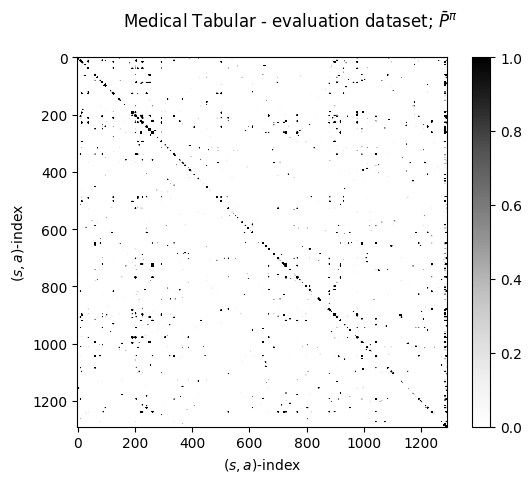

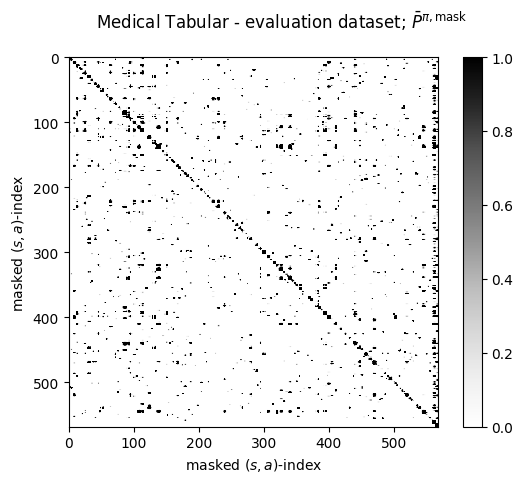

# ---------------------------------------------------------------- # 



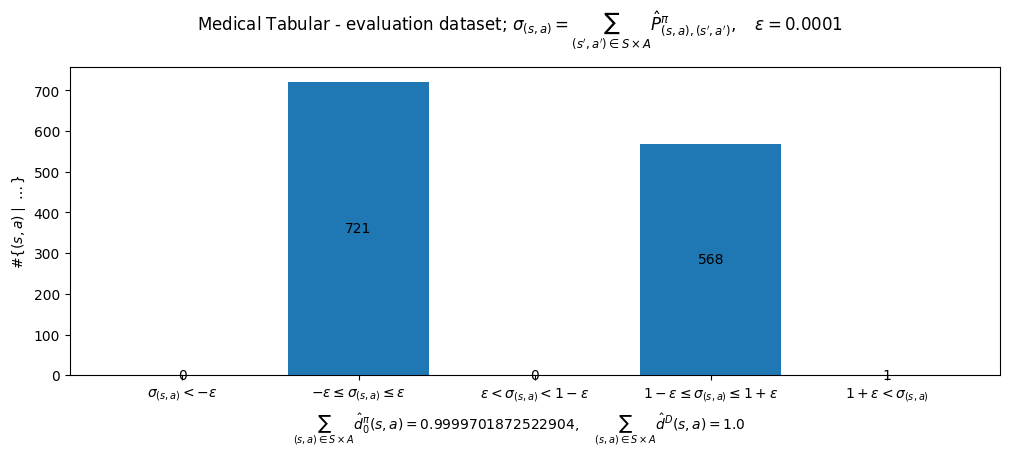

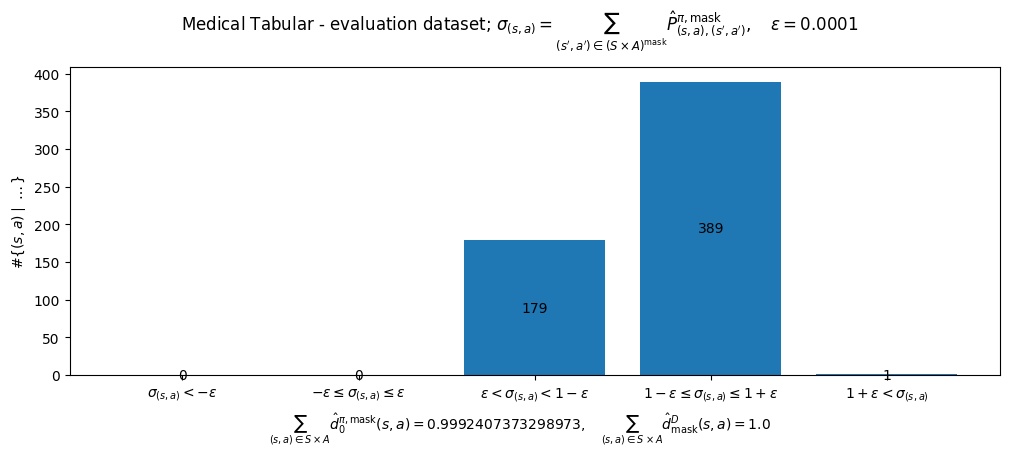

# ---------------------------------------------------------------- # 



In [ ]:
name = "evaluation"

test_auxiliary_estimates(
    auxiliary_estimates=auxiliary_estimates[name],
    title_prefix=f"Medical Tabular - {name} dataset",
    dir=os.path.join(dir_images["tabular"], "auxiliary estimates"),
)

## Environments

In [ ]:
def get_act_model_exploratory(obs):
    with warnings.catch_warnings(action="ignore", category=UserWarning):
        action_masks = env_test.action_masks()

    act, _ = model["exploratory"].predict(obs, action_masks=action_masks)
    return act

def get_act_model_evaluation(obs):
    with warnings.catch_warnings(action="ignore", category=UserWarning):
        action_masks = env_test.action_masks()

    act, _ = model["evaluation"].predict(obs, action_masks=action_masks)
    return act

In [ ]:
test_env(
    env=env_test,
    get_act=get_act_model_exploratory,
    num_trajectory=1_000,
    verbosity=1,
)

100%|██████████| 1000/1000 [00:04<00:00, 249.20it/s]


{'distinct_absolute': (5.895, 3.860825688890914),
 'distinct_relative': (0.5943034526856827, 0.2549477151053652),
 'all': (13.635, 12.702195676338798)}

In [ ]:
test_env(
    env=env_test,
    get_act=get_act_model_evaluation,
    num_trajectory=1_000,
    verbosity=1,
)

100%|██████████| 1000/1000 [00:04<00:00, 217.89it/s]


{'distinct_absolute': (5.765, 3.7357428980056966),
 'distinct_relative': (0.5478743143271877, 0.26124926214474836),
 'all': (15.838, 21.97457066702328)}